# **FIRST APPROACH**

In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import warnings
import seaborn as sns
from sklearn.tree import plot_tree

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

In [ ]:
%load_ext cuml.accel

The cuml.accel extension is already loaded. To reload it, use:
  %reload_ext cuml.accel


In [ ]:
# import csv
#file = os.path.join(os.getcwd(), "dataset.xlsx")
df= pd.read_excel("/content/dataset.xlsx")


#df.dropna(subset=["AQI"], inplace=True)
print(df)

         State                 UTC  Value_NO2  Value_CO  Value_OZONE  \
0      Arizona 2025-09-16 23:00:00  10.333333  0.200000    46.931818   
1      Arizona 2025-09-17 00:00:00   6.566667  0.200000    44.568182   
2      Arizona 2025-09-17 01:00:00   6.383333  0.157143    42.113636   
3      Arizona 2025-09-17 02:00:00  10.400000  0.162500    39.045455   
4      Arizona 2025-09-17 03:00:00  11.100000  0.187500    35.977273   
...        ...                 ...        ...       ...          ...   
12119  Wyoming 2025-10-04 19:00:00   1.142857  0.066667    33.555556   
12120  Wyoming 2025-10-04 20:00:00   1.428571  0.066667    35.111111   
12121  Wyoming 2025-10-04 21:00:00   3.000000  0.133333    35.888889   
12122  Wyoming 2025-10-04 22:00:00   1.357143  0.050000    36.277778   
12123  Wyoming 2025-10-04 23:00:00   1.533333  0.075000    35.236842   

       Value_PM10  Value_PM25  Value_SO2        AQI  
0       20.500000    4.709091   0.114286  43.590909  
1       21.521739    4.7590

In [ ]:
df.isnull().sum()

,0
State,0
UTC,0
Value_NO2,0
Value_CO,0
Value_OZONE,0
Value_PM10,0
Value_PM25,0
Value_SO2,0
AQI,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12124 entries, 0 to 12123
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   State        12124 non-null  object        
 1   UTC          12124 non-null  datetime64[ns]
 2   Value_NO2    12124 non-null  float64       
 3   Value_CO     12124 non-null  float64       
 4   Value_OZONE  12124 non-null  float64       
 5   Value_PM10   12124 non-null  float64       
 6   Value_PM25   12124 non-null  float64       
 7   Value_SO2    12124 non-null  float64       
 8   AQI          12124 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 852.6+ KB


In [ ]:
# Prepare features and target
# Encode categorical variables
label_encoder = LabelEncoder()
df['State_encoded'] = label_encoder.fit_transform(df['State'])
df['UTC'] = pd.to_datetime(df['UTC'])

In [ ]:
# Extract useful datetime features
df['Year'] = df['UTC'].dt.year
df['Month'] = df['UTC'].dt.month
df['Day'] = df['UTC'].dt.day
df['Hour'] = df['UTC'].dt.hour

In [ ]:
# Select features (excluding original City and Datetime, and target PM2.5)
feature_columns = ['State_encoded', 'Year', 'Month', 'Day', 'Hour', 'Value_PM10', 'Value_NO2', 'Value_CO', 'Value_SO2', 'Value_OZONE', 'Value_PM25']
X = df[feature_columns].fillna(df[feature_columns].median())  # Handle remaining NaN in features
y = df['AQI'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Train model
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, oob_score=True, random_state=0)

In [ ]:
print(f"Model trained successfully!")
print(f"OOB Score: {regressor.oob_score_:.4f}")

Model trained successfully!
OOB Score: 0.8528


In [ ]:
from sklearn.metrics import mean_squared_error

predictions = regressor.predict(X_test)

# Evaluate on test set
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (Test): {mse:.4f}')
r2 = r2_score(y_test, predictions)
print(f'R-squared (Test): {r2:.4f}')

Mean Squared Error (Test): 1.5018
R-squared (Test): 0.9878


In [ ]:
# Also evaluate on training set to check for overfitting
train_predictions = regressor.predict(X_train)
train_mse = mean_squared_error(y_train, train_predictions)
train_r2 = r2_score(y_train, train_predictions)
print(f'\nMean Squared Error (Train): {train_mse:.4f}')
print(f'R-squared (Train): {train_r2:.4f}')


Mean Squared Error (Train): 0.3426
R-squared (Train): 0.9973


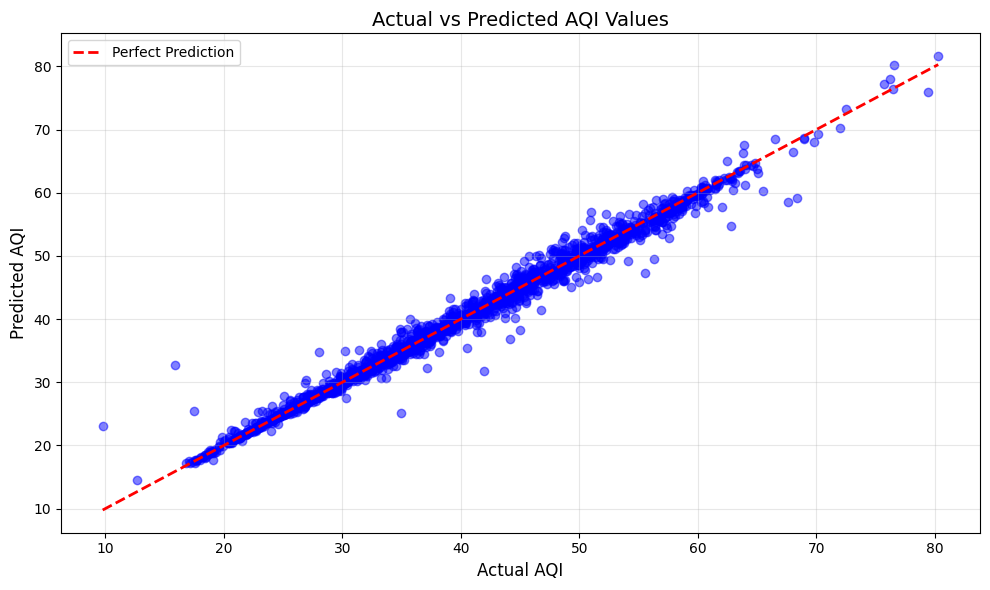

In [ ]:
# Actual vs predicted scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual AQI', fontsize=12)
plt.ylabel('Predicted AQI', fontsize=12)
plt.title('Actual vs Predicted AQI Values', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

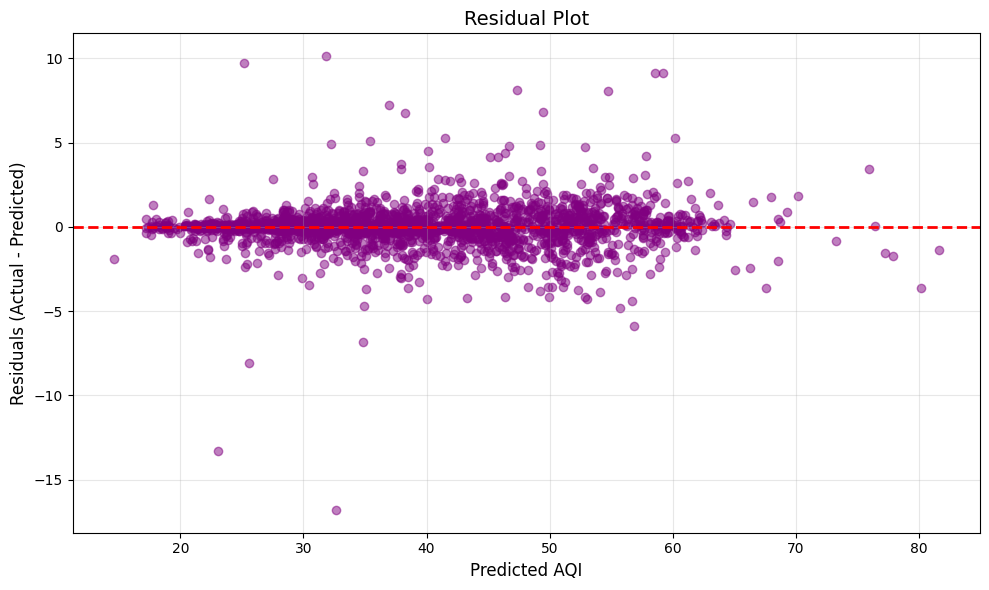

In [ ]:
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted AQI', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.title('Residual Plot', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

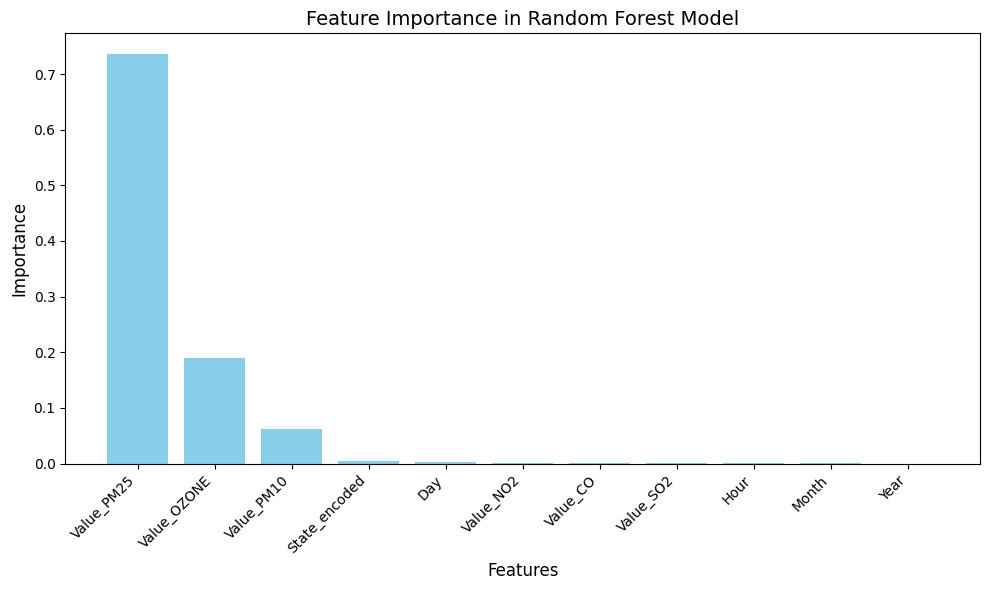

In [ ]:
feature_importance = regressor.feature_importances_
features = feature_columns
indices = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance[indices], color='skyblue')
plt.xticks(range(len(feature_importance)), [features[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Feature Importance in Random Forest Model', fontsize=14)
plt.tight_layout()
plt.show()

### DIFFERENT APPROACH

In [ ]:
# import csv
#file = os.path.join(os.getcwd(), "dataset.xlsx")
df= pd.read_excel("/content/dataset.xlsx")


#df.dropna(subset=["AQI"], inplace=True)
print(df)

         State                 UTC  Value_NO2  Value_CO  Value_OZONE  \
0      Arizona 2025-09-16 23:00:00  10.333333  0.200000    46.931818   
1      Arizona 2025-09-17 00:00:00   6.566667  0.200000    44.568182   
2      Arizona 2025-09-17 01:00:00   6.383333  0.157143    42.113636   
3      Arizona 2025-09-17 02:00:00  10.400000  0.162500    39.045455   
4      Arizona 2025-09-17 03:00:00  11.100000  0.187500    35.977273   
...        ...                 ...        ...       ...          ...   
12119  Wyoming 2025-10-04 19:00:00   1.142857  0.066667    33.555556   
12120  Wyoming 2025-10-04 20:00:00   1.428571  0.066667    35.111111   
12121  Wyoming 2025-10-04 21:00:00   3.000000  0.133333    35.888889   
12122  Wyoming 2025-10-04 22:00:00   1.357143  0.050000    36.277778   
12123  Wyoming 2025-10-04 23:00:00   1.533333  0.075000    35.236842   

       Value_PM10  Value_PM25  Value_SO2        AQI  
0       20.500000    4.709091   0.114286  43.590909  
1       21.521739    4.7590

In [ ]:
label_encoder = LabelEncoder()
df['State_encoded'] = label_encoder.fit_transform(df['State'])
df['UTC'] = pd.to_datetime(df['UTC'])

In [ ]:
df['Year'] = df['UTC'].dt.year
df['Month'] = df['UTC'].dt.month
df['Day'] = df['UTC'].dt.day
df['Hour'] = df['UTC'].dt.hour

In [ ]:
import pandas as pd
df_ts = df.copy()
df_ts["UTC"] = pd.to_datetime(df_ts["UTC"])
# Option A: one global model with State as category
df_ts = df_ts.sort_values(["State","UTC"]).set_index("UTC")


In [ ]:
df_ts

,State,Value_NO2,Value_CO,Value_OZONE,Value_PM10,Value_PM25,Value_SO2,AQI,State_encoded,Year,Month,Day,Hour
UTC,,,,,,,,,,,,,
2025-09-16 23:00:00,Arizona,10.333333,0.200000,46.931818,20.500000,4.709091,0.114286,43.590909,0,2025,9,16,23
2025-09-17 00:00:00,Arizona,6.566667,0.200000,44.568182,21.521739,4.759091,0.100000,41.295455,0,2025,9,17,0
2025-09-17 01:00:00,Arizona,6.383333,0.157143,42.113636,7.765957,4.390909,0.071429,39.022727,0,2025,9,17,1
2025-09-17 02:00:00,Arizona,10.400000,0.162500,39.045455,33.425532,4.440909,0.071429,36.136364,0,2025,9,17,2
2025-09-17 03:00:00,Arizona,11.100000,0.187500,35.977273,30.723404,4.336364,0.085714,33.340909,0,2025,9,17,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-04 19:00:00,Wyoming,1.142857,0.066667,33.555556,13.666667,2.673333,0.250000,31.000000,27,2025,10,4,19
2025-10-04 20:00:00,Wyoming,1.428571,0.066667,35.111111,9.916667,1.600000,0.250000,32.555556,27,2025,10,4,20
2025-10-04 21:00:00,Wyoming,3.000000,0.133333,35.888889,8.416667,1.206667,0.250000,33.277778,27,2025,10,4,21


In [ ]:
import pandas as pd

# Ensure sorted by State and time
df_ts = df_ts.sort_values(["State", "UTC"])

target_cols = ["AQI","Value_NO2", "Value_CO", "Value_OZONE", "Value_SO2"]
lags = [6, 24]
rolls = [3, 6, 12, 24]

def add_lag_features(group):
    group = group.copy()
    for col in target_cols:
        if col == "AQI":
            # Only AQI_lag6
            group[f"{col}_lag6"] = group[col].shift(6)
        else:
            # Pollutants get multiple lags and rolling stats
            for lag in lags:
                group[f"{col}_lag{lag}"] = group[col].shift(lag)
            for win in rolls:
                group[f"{col}_rollmean{win}"] = group[col].rolling(win).mean()
                group[f"{col}_rollstd{win}"] = group[col].rolling(win).std()
    return group

df_feat = df_ts.groupby("State", group_keys=False).apply(add_lag_features)
df_feat = df_feat.dropna().reset_index(drop=True)

print(df_feat.shape)
df_feat.head()




(11452, 54)


,State,Value_NO2,Value_CO,Value_OZONE,Value_PM10,Value_PM25,Value_SO2,AQI,State_encoded,Year,...,Value_SO2_lag6,Value_SO2_lag24,Value_SO2_rollmean3,Value_SO2_rollstd3,Value_SO2_rollmean6,Value_SO2_rollstd6,Value_SO2_rollmean12,Value_SO2_rollstd12,Value_SO2_rollmean24,Value_SO2_rollstd24
0,Arizona,7.183333,0.1875,48.227273,33.466667,4.663636,0.071429,44.795455,0,2025,...,0.071429,0.114286,0.057143,0.014286,0.080952,0.030861,0.101190,0.056312,0.076587,0.050550
1,Arizona,7.700000,0.1750,46.659091,12.369565,4.872727,0.100000,43.545455,0,2025,...,0.085714,0.100000,0.076190,0.021822,0.083333,0.031837,0.096429,0.053496,0.076587,0.050550
2,Arizona,9.916667,0.2000,44.204545,37.760870,5.181818,0.100000,41.113636,0,2025,...,0.100000,0.071429,0.090476,0.016496,0.083333,0.031837,0.104762,0.044067,0.077778,0.050759
3,Arizona,10.600000,0.1875,41.295455,40.565217,5.709091,0.057143,38.363636,0,2025,...,0.128571,0.071429,0.085714,0.024744,0.071429,0.023905,0.096429,0.042694,0.077183,0.050920
4,Arizona,10.316667,0.1875,38.906977,42.347826,6.036364,0.133333,36.934783,0,2025,...,0.042857,0.085714,0.096825,0.038194,0.086508,0.030029,0.094444,0.040090,0.079167,0.052179


In [ ]:
df_feat.columns

Index(['State', 'Value_NO2', 'Value_CO', 'Value_OZONE', 'Value_PM10',
       'Value_PM25', 'Value_SO2', 'AQI', 'State_encoded', 'Year', 'Month',
       'Day', 'Hour', 'AQI_lag6', 'Value_NO2_lag6', 'Value_NO2_lag24',
       'Value_NO2_rollmean3', 'Value_NO2_rollstd3', 'Value_NO2_rollmean6',
       'Value_NO2_rollstd6', 'Value_NO2_rollmean12', 'Value_NO2_rollstd12',
       'Value_NO2_rollmean24', 'Value_NO2_rollstd24', 'Value_CO_lag6',
       'Value_CO_lag24', 'Value_CO_rollmean3', 'Value_CO_rollstd3',
       'Value_CO_rollmean6', 'Value_CO_rollstd6', 'Value_CO_rollmean12',
       'Value_CO_rollstd12', 'Value_CO_rollmean24', 'Value_CO_rollstd24',
       'Value_OZONE_lag6', 'Value_OZONE_lag24', 'Value_OZONE_rollmean3',
       'Value_OZONE_rollstd3', 'Value_OZONE_rollmean6', 'Value_OZONE_rollstd6',
       'Value_OZONE_rollmean12', 'Value_OZONE_rollstd12',
       'Value_OZONE_rollmean24', 'Value_OZONE_rollstd24', 'Value_PM25_lag6',
       'Value_PM25_lag24', 'Value_PM25_rollmean3', 'Value_P

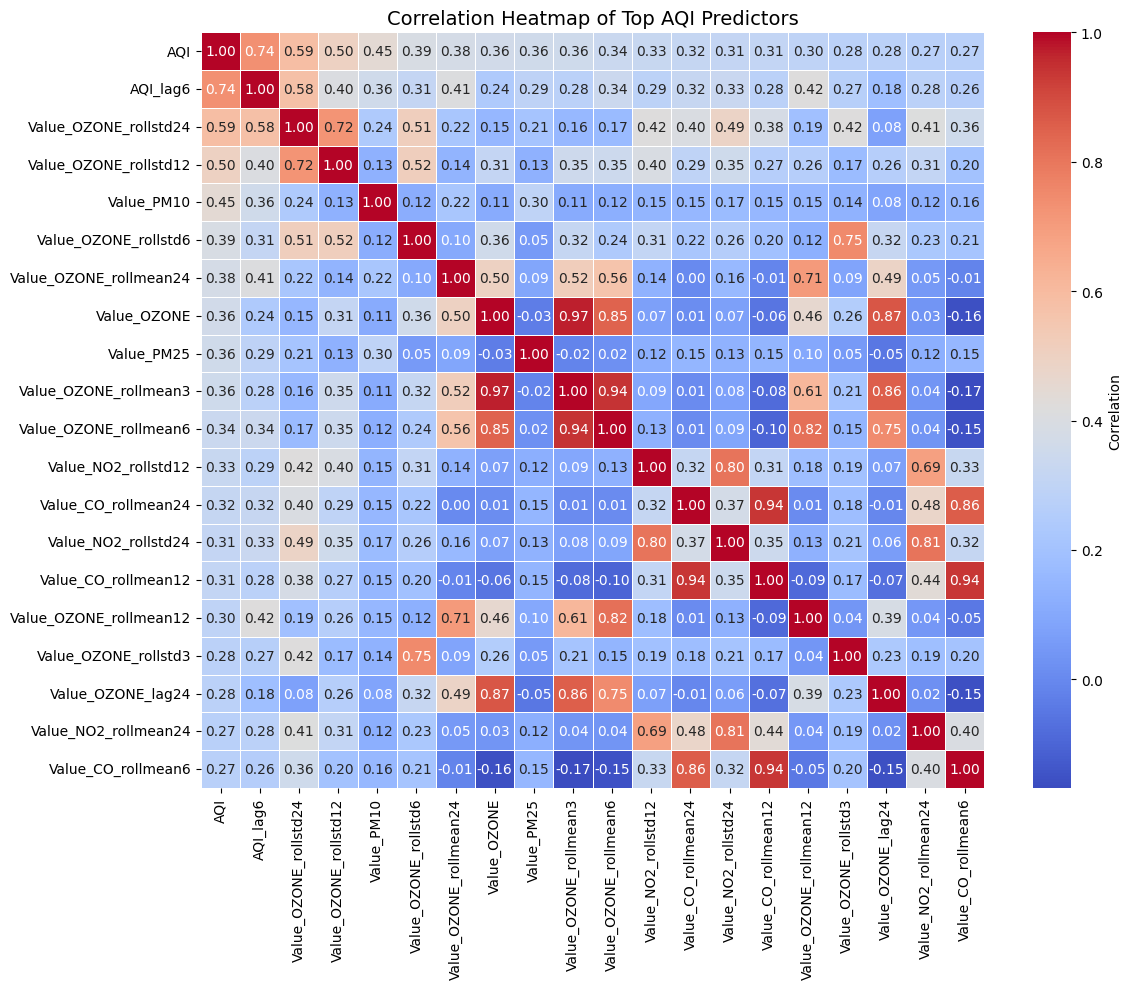

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns only
numeric_df = df_feat.select_dtypes(include=["float64", "int64"])

# Compute correlation matrix
corr = numeric_df.corr()

# Focus on top features correlated with AQI
top_features = corr["AQI"].abs().sort_values(ascending=False).head(20).index
corr_subset = corr.loc[top_features, top_features]

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_subset,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'}
)
plt.title("Correlation Heatmap of Top AQI Predictors", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

feature_cols = [c for c in df_feat.columns
                if c not in ["UTC","State","AQI"]]

X = df_feat[feature_cols]
y = df_feat["AQI"]

# simple time-aware split
tscv = TimeSeriesSplit(n_splits=5)
train_idx, valid_idx = list(tscv.split(X))[-1]
X_tr, X_va = X.iloc[train_idx], X.iloc[valid_idx]
y_tr, y_va = y.iloc[train_idx], y.iloc[valid_idx]

model = XGBRegressor(
    n_estimators=5000,
    learning_rate=0.02,
    max_depth=4,              # ↓ Reduce from 5
    min_child_weight=15,       # ↑ Increase from 10
    subsample=0.6,
    colsample_bytree=0.6,
    colsample_bylevel=0.6,    # ← Add per-level sampling
    reg_alpha=2.0,            # ↑ Increase L1
    reg_lambda=5.0,           # ↑ Increase L2
    gamma=0.5,                # ↑ Increase split penalty
    tree_method="hist",
    random_state=42
)

model.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    verbose=True,
)
pred_va = model.predict(X_va)

[0]	validation_0-rmse:9.23469
[1]	validation_0-rmse:9.05282
[2]	validation_0-rmse:8.89653
[3]	validation_0-rmse:8.73865
[4]	validation_0-rmse:8.57802
[5]	validation_0-rmse:8.45299
[6]	validation_0-rmse:8.32698
[7]	validation_0-rmse:8.15899
[8]	validation_0-rmse:8.02056
[9]	validation_0-rmse:7.91734
[10]	validation_0-rmse:7.76367
[11]	validation_0-rmse:7.61437
[12]	validation_0-rmse:7.50900
[13]	validation_0-rmse:7.42649
[14]	validation_0-rmse:7.29299
[15]	validation_0-rmse:7.20793
[16]	validation_0-rmse:7.12733
[17]	validation_0-rmse:7.04101
[18]	validation_0-rmse:6.92974
[19]	validation_0-rmse:6.84039
[20]	validation_0-rmse:6.74279
[21]	validation_0-rmse:6.61937
[22]	validation_0-rmse:6.51178
[23]	validation_0-rmse:6.39292
[24]	validation_0-rmse:6.28385
[25]	validation_0-rmse:6.18596
[26]	validation_0-rmse:6.07333
[27]	validation_0-rmse:5.98009
[28]	validation_0-rmse:5.92491
[29]	validation_0-rmse:5.82129
[30]	validation_0-rmse:5.79072
[31]	validation_0-rmse:5.73983
[32]	validation_0-

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae  = mean_absolute_error(y_va, pred_va)
mse  = mean_squared_error(y_va, pred_va)
rmse = np.sqrt(mse)
r2   = 1 - np.sum((y_va - pred_va)**2) / np.sum((y_va - np.mean(y_va))**2)

print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")


MAE:  1.539
RMSE: 2.648
R²:   0.914


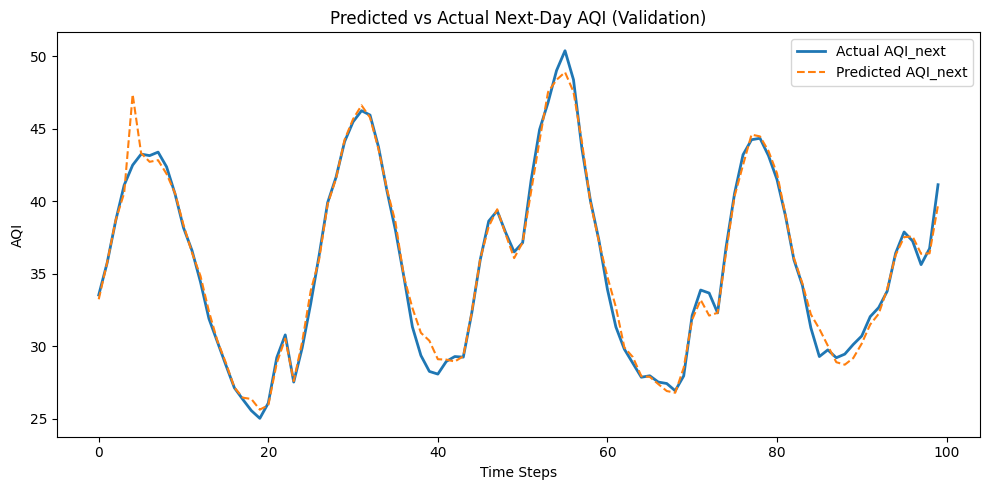

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_va.values[:100], label="Actual AQI_next", linewidth=2)
plt.plot(pred_va[:100], label="Predicted AQI_next", linestyle='--')
plt.title("Predicted vs Actual Next-Day AQI (Validation)")
plt.xlabel("Time Steps")
plt.ylabel("AQI")
plt.legend()
plt.tight_layout()
plt.show()

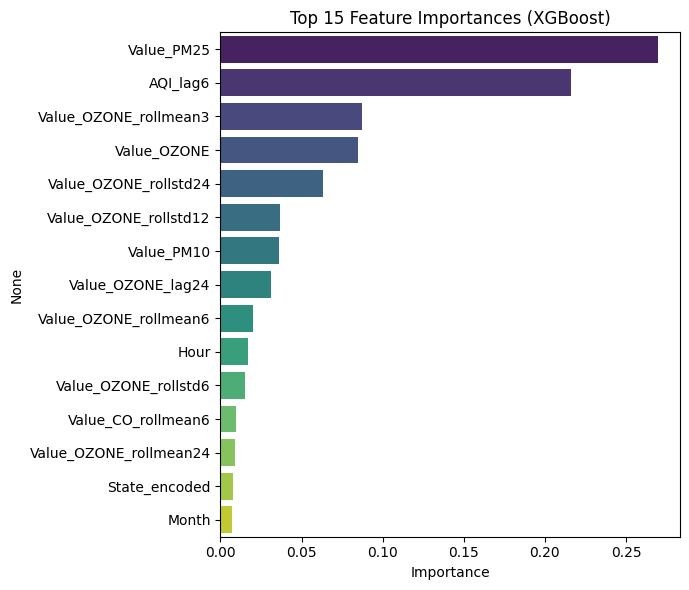

In [ ]:
import pandas as pd
import seaborn as sns

importance = pd.Series(model.feature_importances_, index=X_tr.columns)
top_features = importance.sort_values(ascending=False).head(15)

plt.figure(figsize=(7,6))
sns.barplot(y=top_features.index, x=top_features.values, palette="viridis")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [ ]:
df_feat.State.unique().shape

(28,)

In [ ]:
import joblib

joblib.dump(model, "aqi_model.pkl")
print("Model saved to aqi_model.pkl")

Model saved to aqi_model.pkl
